In [1]:
!pip install torchsummary mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 65.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 MB 38.1 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 MB 40.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 23.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.1
    Uninstalling protobuf-4.25.1:
      Successfully uninstalled protobuf-4.25.1


In [2]:
import sys
sys.path.append("..")

import utils
device = utils.device

Using cpu as device


In [3]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image as PILImage
import os
import pandas as pd
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_folder = "images"
        self.label_folder = "labels"
        self.keypoints_folder = "keypoints"
        self.image_path = os.path.join(root_dir, self.image_folder)
        self.label_path = os.path.join(root_dir, self.label_folder)
        self.keypoints_path = os.path.join(root_dir, self.keypoints_folder)
        # self.image_list = os.listdir(self.image_path)
        # self.label_list = os.listdir(self.label_path)
        self.keypoints_list = os.listdir(self.keypoints_path)
        self.keypoints_list.remove("all_keypoints.csv")
        self.keypoints_list.remove(".ipynb_checkpoints")
        self.image_list = [filename.replace(".csv", ".jpg") for filename in self.keypoints_list]
        self.label_list = [filename.replace(".csv", ".txt") for filename in self.keypoints_list]
        
    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        # Important: Some images do not have corresponding keypoints!
        # print(self.image_list[0], self.label_list[0], self.keypoints_list[0])
        # print(len(self.image_list), len(self.label_list), len(self.keypoints_list))
        img_name = os.path.join(self.image_path, self.image_list[idx])
        label_name = os.path.join(self.label_path, self.label_list[idx])
        keypoints_name = os.path.join(self.keypoints_path, self.keypoints_list[idx])
        
        image = PILImage.open(img_name).convert("RGB")

        with open(label_name, "r") as f:
            label = int(f.readline().split(" ")[0])

        if self.transform:
            image = self.transform(image)

        data = pd.read_csv(keypoints_name, delimiter=";")
        features = torch.tensor(data.iloc[:, 1:].astype(np.float32).transpose().values)

        # print(image.shape, features.shape)
        
        features = features.unsqueeze(1).expand(-1, 224, -1)  # Adds a new dimension at position 1
        # print(image.shape, features.shape)
        combined_features = torch.cat((features, image), dim=2)
        # # Concatenate the tensors along the second dimension
        # all_features = torch.cat((features, image), dim=1)
        
        return combined_features, label


In [4]:
from torch.utils.data import DataLoader
from torchvision import transforms

# Example transforms, adjust as needed
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = CustomDataset(root_dir="../train", transform=transform)
val_dataset = CustomDataset(root_dir="../valid", transform=transform)
test_dataset = CustomDataset(root_dir="../test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Amount of train pictures: {len(train_dataset)}")
print(f"Amount of validation pictures: {len(val_dataset)}")
print(f"Amount of test pictures: {len(test_dataset)}")

Amount of train pictures: 1377
Amount of validation pictures: 396
Amount of test pictures: 195


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

# num_classes = len(data["names"])
num_classes = utils.num_classes

# Define a simple neural network
class SimpleCNNPixelMediaPipe(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNNPixelMediaPipe, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p = 0.2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 14 * 43, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.fc3 = nn.Linear(32 * 56 //2 * 56 //2, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


model = SimpleCNNPixelMediaPipe(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

dummy_input = torch.randn(64, 3, 224, 224 + 468).to(device)
summary(model, dummy_input.size()[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 692]             448
              ReLU-2         [-1, 16, 224, 692]               0
         MaxPool2d-3         [-1, 16, 112, 346]               0
            Conv2d-4         [-1, 32, 112, 346]           4,640
              ReLU-5         [-1, 32, 112, 346]               0
         MaxPool2d-6          [-1, 32, 56, 173]               0
            Conv2d-7          [-1, 64, 56, 173]          18,496
              ReLU-8          [-1, 64, 56, 173]               0
         MaxPool2d-9           [-1, 64, 28, 86]               0
           Conv2d-10          [-1, 128, 28, 86]          73,856
             ReLU-11          [-1, 128, 28, 86]               0
        MaxPool2d-12          [-1, 128, 14, 43]               0
          Flatten-13                [-1, 77056]               0
           Linear-14                  [

Epoch 50/50: 100%|██████████| 22/22 [02:50<00:00,  7.75s/batch, Loss=0.0354]


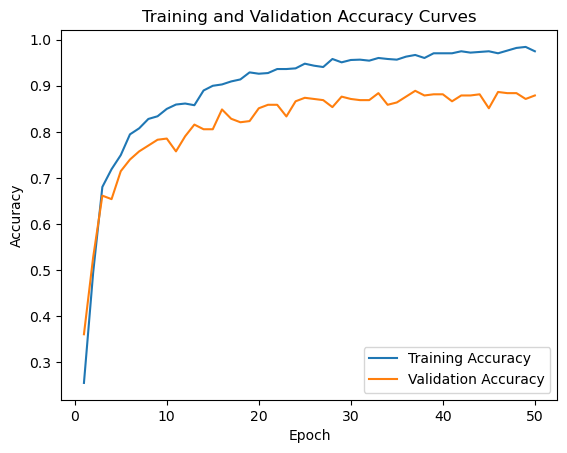

0.9745824255628177 0.8787878787878788


In [6]:
parameters = {"epochs": 50,
              "trainloader": train_loader,
              "valloader": val_loader,
              "testloader": test_loader,
              "criterion": criterion,
              "optimizer": optimizer}

train_accuracies, val_accuracies = utils.train_and_plot(model, parameters)
print(train_accuracies[-1], val_accuracies[-1])

In [7]:
torch.save(model.state_dict(), "pixel_keypoints_v1_50.pth")

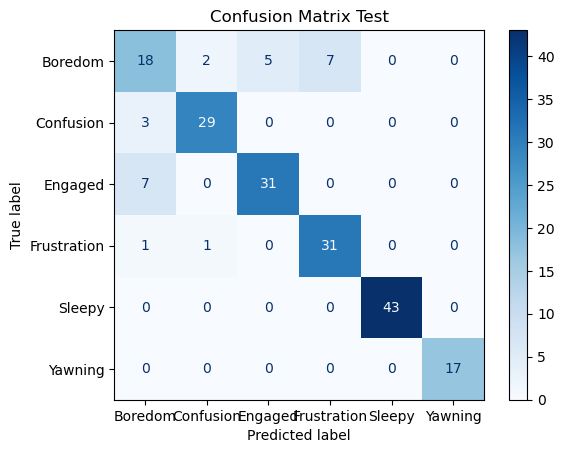

In [8]:
utils.plot_confusionmatrix(model, parameters)

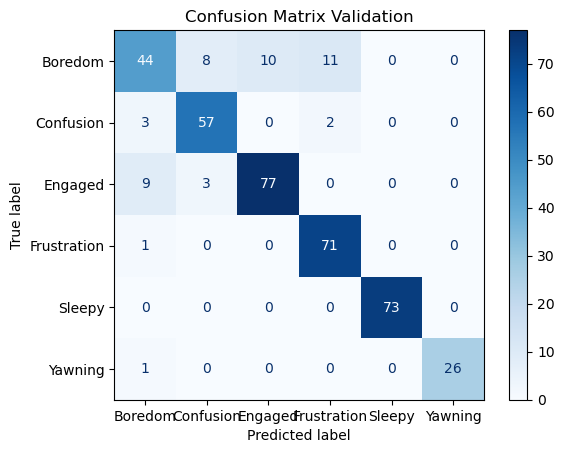

In [9]:
import yaml
yaml_file_path = "/project_ghent/Master-Thesis/Roboflow/AffectiveStates/AffectiveStates/data.yaml"

with open(yaml_file_path, 'r') as file:
    data = yaml.safe_load(file)
    
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming you have a DataLoader named validation_loader and a trained model
model.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

cm = confusion_matrix(all_labels, all_predictions)
class_names = [str(i) for i in data["names"]]  # Replace with actual class names or labels

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format=".4g")

plt.title("Confusion Matrix Validation")
plt.show()